# Final Project Phase 4 - Home Credit Default Risk

Spring 2024

**Team Members:**
- Glen Colletti
- Alex Bordanca
- Paul Miller





# Abstract



Our project aimed to predict loan repayment based on the data available at the time of application. To accomplish this the team down selected features in the application train data; implemented Recency, Frequency, and Monetary Value features; trained KNN, XGBoost, and Linear Regression models; as well as a deep learning model. We attempted to account for this by oversampling the minority class. 

Along the way we discovered an imbalance in the TARGET data causing our models to overpredict the majority class. The team identified correlations among the training set features, motivating us to select only one of any set of correlated features, reducing our model complexity with minimal impact on predictions. 

Other data anomalies included erroneous entries implying 1000-year credit history, and features with missing data. Mitigations for these anomalies included removal and imputing. By building our mitigations into data pipelines we were able to generalize our data preprocessing to our four model types with minimal rework. 

The Neural Network model yielded the strongest prediction performance with 60.5% F1 score and 60.5% ROC_AUC.  

# Data Lineage

The data originated from the Kaggle source. Throughout out the course of building, training, and refining the models, the underlying datasets underwent several transformations detailed below:
- Appending to the initial train dataset via left join a dataset consisting of RFM (Recency, Frequency, Monetary Value) metrics extracted from the previous_applications dataset. The recency feature was calculated as the max (of DAYS_DECISION) to capture the most recent decision date; the frequency as the range of decision dates divided by the number of previous applications (flagged by distinct number of SK_ID_PREV grouped by SK_ID_CURR); and the monetary value was the sum of total amounts credited.
- Within the pipelines, the data was further transformed to control for scaling issues and missing values. Numerical features' missing values were imputed with the median, and then standard scaled. Categorical features' missing values were imputed with the most frequent value within the column.

# Neural Network

## delete me

Neural Network/PyTorch (HCDR)
-- Implement Neural Network (NN) model
-- Experiment with at least 2 different Network architecture.
-- Report neural network architecture in string form (e.g., 100 - 200 - Relu - 300 - Relu - 2 Softmax )

To implement the Neural Network (Deep Learning) models a pipeline was adapted from Homework 11. The pipeline allowed us to train and test Neural Networks with dynamically defined hidden layers, optimization functions, activation functions, and loss functions. We improved upon the intial code base by adding F1 scores and AUC_ROC scores. A feature was added for the code to exit the epoch training cycle if subsequent models were no longer improving, indicating the model had converged.

Intially we faced challenges with models hitting a performance ceiling around 92% accuracy. Upon further inspection we realized the models were learning to over predict the majoirty class becuase the TARGET data was 92% majority class. After added an oversampling step to the data processing to balance the majority and minority class the models hit a ceiling of ~60% performance.

## Neural Network Pipeline


![Image](NNBlockDiagram.PNG)

![Image](NNBlockDiagram_train.PNG)

## Architecture 1

We attempted many different configuration of neural networks, the first using Adadelta and a configuration in the form: 34-50-50-25-2

In [15]:
import pandas as pd
from __future__ import print_function

import numpy as np

np.random.seed(0)

from pandasql import sqldf

import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score,roc_auc_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from imblearn.over_sampling import RandomOverSampler

## Load data

In [2]:
train_data = pd.read_csv('data/application_train.csv') #data we have the target class for
test_data = pd.read_csv('data/application_test.csv') #data we need to predict target class for

print (f'Loaded {train_data.shape[0]:,} rows in training set.')

print (f'Loaded {test_data.shape[0]:,} rows in testing set.')


Loaded 307,511 rows in training set.
Loaded 48,744 rows in testing set.


In [3]:
PrevApp_data = pd.read_csv('data/previous_application.csv') #data from previous applications to Home Credit
print(np.shape(PrevApp_data))
col_names = PrevApp_data.columns.values.tolist()
col_names.sort()
print(col_names)

(1670214, 37)
['AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE', 'CHANNEL_TYPE', 'CNT_PAYMENT', 'CODE_REJECT_REASON', 'DAYS_DECISION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_TERMINATION', 'FLAG_LAST_APPL_PER_CONTRACT', 'HOUR_APPR_PROCESS_START', 'NAME_CASH_LOAN_PURPOSE', 'NAME_CLIENT_TYPE', 'NAME_CONTRACT_STATUS', 'NAME_CONTRACT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PAYMENT_TYPE', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'NAME_SELLER_INDUSTRY', 'NAME_TYPE_SUITE', 'NAME_YIELD_GROUP', 'NFLAG_INSURED_ON_APPROVAL', 'NFLAG_LAST_APPL_IN_DAY', 'PRODUCT_COMBINATION', 'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED', 'SELLERPLACE_AREA', 'SK_ID_CURR', 'SK_ID_PREV', 'WEEKDAY_APPR_PROCESS_START']


## Join and filter previous application data with train data

In [7]:
augmented_train_data = sqldf('''
with rfm as (select
  SK_ID_CURR, sum(AMT_CREDIT) as MONETARY_VALUE,
  max(DAYS_DECISION) as RECENCY_FEATURE,
  (max(DAYS_DECISION) - min(DAYS_DECISION))/COUNT(DISTINCT SK_ID_PREV) as FREQUENCY_FEATURE
from PrevApp_data
where AMT_CREDIT <> 0
group by 1
)
select train.*, rfm.RECENCY_FEATURE, rfm.FREQUENCY_FEATURE, rfm.MONETARY_VALUE
from train_data train
left join rfm
on train.SK_ID_CURR = rfm.SK_ID_CURR
''')
augmented_train_data

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,RECENCY_FEATURE,FREQUENCY_FEATURE,MONETARY_VALUE
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0.0,0.0,0.0,0.0,0.0,1.0,-606.0,0.0,179055.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0.0,0.0,0.0,0.0,0.0,0.0,-746.0,531.0,1452573.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,-815.0,0.0,20106.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,NaN,NaN,NaN,NaN,NaN,NaN,-181.0,72.0,2625259.5
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0.0,0.0,0.0,0.0,0.0,0.0,-374.0,330.0,999832.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,-273.0,0.0,40455.0
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,NaN,NaN,NaN,NaN,NaN,NaN,-2497.0,0.0,56821.5
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,1.0,0.0,0.0,1.0,0.0,1.0,-1909.0,471.0,41251.5
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,-277.0,22.0,268879.5


In [9]:
filtered_train_data = sqldf('''
SELECT
  TARGET,
  FLOORSMAX_MEDI,
  ELEVATORS_MEDI,
  FLOORSMIN_MEDI,
  AMT_CREDIT,
  TOTALAREA_MODE,
  DAYS_EMPLOYED,
  OBS_30_CNT_SOCIAL_CIRCLE,
  CNT_FAM_MEMBERs,
  CNT_CHILDREN,
  OWN_CAR_AGE,
  DAYS_ID_PUBLISH,
  DAYS_LAST_PHONE_CHANGE,
  CODE_GENDER,
  OCCUPATION_TYPE,
  AMT_INCOME_TOTAL,
  RECENCY_FEATURE,
  FREQUENCY_FEATURE,
  MONETARY_VALUE
FROM
  augmented_train_data

''')



In [10]:
augmented_test_data = sqldf('''
with rfm as (select
  SK_ID_CURR, sum(AMT_CREDIT) as MONETARY_VALUE,
  max(DAYS_DECISION) as RECENCY_FEATURE,
  (max(DAYS_DECISION) - min(DAYS_DECISION))/COUNT(DISTINCT SK_ID_PREV) as FREQUENCY_FEATURE
from PrevApp_data
where AMT_CREDIT <> 0
group by 1
)
select train.*, rfm.RECENCY_FEATURE, rfm.FREQUENCY_FEATURE, rfm.MONETARY_VALUE
from test_data train
left join rfm
on train.SK_ID_CURR = rfm.SK_ID_CURR
''')
filtered_test_data = sqldf('''
SELECT
  FLOORSMAX_MEDI,
  ELEVATORS_MEDI,
  FLOORSMIN_MEDI,
  AMT_CREDIT,
  TOTALAREA_MODE,
  DAYS_EMPLOYED,
  OBS_30_CNT_SOCIAL_CIRCLE,
  CNT_FAM_MEMBERs,
  CNT_CHILDREN,
  OWN_CAR_AGE,
  DAYS_ID_PUBLISH,
  DAYS_LAST_PHONE_CHANGE,
  CODE_GENDER,
  OCCUPATION_TYPE,
  AMT_INCOME_TOTAL,
  RECENCY_FEATURE,
  FREQUENCY_FEATURE,
  MONETARY_VALUE
FROM
  augmented_test_data

''')
filtered_test_data


,FLOORSMAX_MEDI,ELEVATORS_MEDI,FLOORSMIN_MEDI,AMT_CREDIT,TOTALAREA_MODE,DAYS_EMPLOYED,OBS_30_CNT_SOCIAL_CIRCLE,CNT_FAM_MEMBERS,CNT_CHILDREN,OWN_CAR_AGE,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,CODE_GENDER,OCCUPATION_TYPE,AMT_INCOME_TOTAL,RECENCY_FEATURE,FREQUENCY_FEATURE,MONETARY_VALUE
0,0.1250,NaN,NaN,568800.0,0.0392,-2329,0.0,2.0,0,NaN,-812,-1740.0,F,None,135000.0,-1740.0,0.0,23787.000
1,NaN,NaN,NaN,222768.0,NaN,-4469,0.0,2.0,0,NaN,-1623,0.0,M,Low-skill Laborers,99000.0,-757.0,0.0,40153.500
2,NaN,NaN,NaN,663264.0,NaN,-4458,0.0,2.0,0,5.0,-3503,-856.0,M,Drivers,202500.0,-273.0,575.0,584536.500
3,0.3750,0.32,0.0417,1575000.0,0.3700,-1866,0.0,4.0,2,NaN,-4208,-1805.0,F,Sales staff,315000.0,-797.0,252.0,464602.500
4,NaN,NaN,NaN,625500.0,NaN,-2191,0.0,3.0,1,16.0,-4262,-821.0,M,None,180000.0,-111.0,355.0,601101.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,NaN,NaN,NaN,412560.0,NaN,-5169,1.0,1.0,0,NaN,-3399,-684.0,F,None,121500.0,-683.0,0.0,254700.000
48740,NaN,NaN,NaN,622413.0,NaN,-1149,2.0,4.0,2,NaN,-3003,0.0,F,Sales staff,157500.0,-770.0,420.0,394816.500
48741,0.3333,0.16,NaN,315000.0,0.1663,-3037,0.0,3.0,1,4.0,-1504,-838.0,F,None,202500.0,-84.0,377.0,265033.665
48742,0.6250,0.16,NaN,450000.0,0.1974,-2731,0.0,2.0,0,NaN,-1364,-2308.0,M,Managers,225000.0,-577.0,432.0,637893.000


## Transformers and pipelines

In [16]:
class ReplaceValuesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.column] = X_copy[self.column].apply(lambda x: 0 if x > 0 else x)
        return X_copy

In [17]:
# Sample data
X = filtered_train_data.drop(columns=['TARGET'])
y = filtered_train_data['TARGET']

Trying naive oversampling minority to match class proportions between zero class and one class

In [18]:
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)

              TARGET
count  307511.000000
mean        0.080729
std         0.272419
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
TARGET    0.080729
dtype: float64
         TARGET
count  565372.0
mean        0.5
std         0.5
min         0.0
25%         0.0
50%         0.5
75%         1.0
max         1.0
TARGET    0.5
dtype: float64


/usr/local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


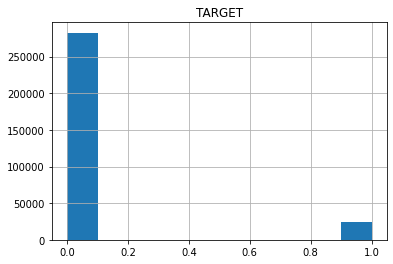

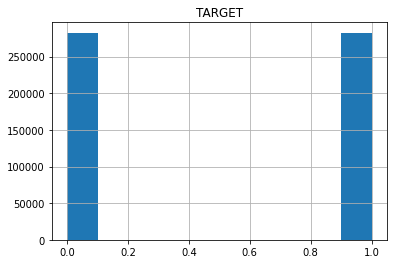

In [19]:
test = pd.DataFrame(y)
test.hist()
print(test.describe())
print(np.sum(test == 1)/(len(test)))

test = pd.DataFrame(y_res)
test.hist()
print(test.describe())
print(np.sum(test == 1)/(len(test)))

In [20]:
y = y_res
X = X_res

In [22]:
# Define column transformer for numerical and categorical features
numeric_features = ['FLOORSMAX_MEDI', 'ELEVATORS_MEDI', 'FLOORSMIN_MEDI',
       'AMT_CREDIT', 'TOTALAREA_MODE', 'DAYS_EMPLOYED',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'CNT_FAM_MEMBERS', 'CNT_CHILDREN',
       'OWN_CAR_AGE', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE']  # List of numerical feature column indices
categorical_features = ['CODE_GENDER','OCCUPATION_TYPE']  # List of categorical feature column indices

numeric_transformer = Pipeline(steps=[
    ('replace_values', ReplaceValuesTransformer(column='DAYS_EMPLOYED')),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())

])

categorical_transformer = Pipeline(steps=[
     ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, shuffle = True)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.15, random_state=42, shuffle=True)

In [25]:
X_train = preprocessor.fit_transform(X_train)
X_validation = preprocessor.transform(X_validation)
X_test = preprocessor.transform(X_test) #Transform test set with the same constants


y_train = y_train.to_numpy()
y_validation = y_validation.to_numpy()
y_test = y_test.to_numpy()

# convert numpy arrays to tensors
X_train_tensor = torch.from_numpy(X_train)
X_valid_tensor = torch.from_numpy(X_validation)
X_test_tensor = torch.from_numpy(X_test)
y_train_tensor = torch.from_numpy(y_train)
y_valid_tensor = torch.from_numpy(y_validation)
y_test_tensor = torch.from_numpy(y_test)

# create TensorDataset in PyTorch
hcdr_train = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
hcdr_valid = torch.utils.data.TensorDataset(X_valid_tensor, y_valid_tensor)
hcdr_test = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

# print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
# create dataloader
# DataLoader is implemented in PyTorch, which will return an iterator to iterate training data by batch.
train_batch_size = 96
valid_test_batch_size = 64
trainloader_hcdr = torch.utils.data.DataLoader(hcdr_train, batch_size=train_batch_size, shuffle=True, num_workers=2)
validloader_hcdr = torch.utils.data.DataLoader(hcdr_valid, batch_size=valid_test_batch_size, shuffle=True, num_workers=2)
testloader_hcdr = torch.utils.data.DataLoader(hcdr_test, batch_size=valid_test_batch_size, shuffle=True, num_workers=2)

## Define NN model (Rectified Linear Unit ver)

In [26]:
def run_hcdr_model(
    hidden_layer_neurons=[32, 16, 8],
    opt=optim.SGD,
    epochs=5,
    learning_rate=1e-3
):

    D_in = X_test.shape[1]  # Input layer neurons depend on the input dataset shape
    D_out = 2  # Output layer neurons - depend on what you're trying to predict, here, 2 classes: 0 and 1

    str_neurons = [str(h) for h in hidden_layer_neurons]
    arch_string = f"{D_in}-{'-'.join(str_neurons)}-{D_out}"

    layers = [
        torch.nn.Linear(D_in, hidden_layer_neurons[0]),  # X.matmul(W1)
        nn.ReLU(),  # ReLU( X.matmul(W1))
    ]

    # Add hidden layers
    for i in range(1, len(hidden_layer_neurons)):
        prev, curr = hidden_layer_neurons[i - 1], hidden_layer_neurons[i]
        layers.append(torch.nn.Linear(prev, curr))
        layers.append(nn.ReLU())


    # Add final layer
    layers.append(nn.Linear(hidden_layer_neurons[-1], D_out)) # Relu( X.matmul(W1)).matmul(W2))

    # Use the nn package to define our model and loss function.
    # use the sequential API makes things simple
    model = torch.nn.Sequential(*layers)

    model.to(device)

    # use Cross Entropy and SGD optimizer.
    loss_fn = nn.CrossEntropyLoss()  #for classfication
    optimizer = opt(model.parameters(), lr=learning_rate)

    #summary(model, (4, 20))
    print('-'*50)
    print('Model:')
    print(model)
    print('-'*50)

    '''
    Training Process:
        Load a batch of data.
        Zero the grad.
        Predict the batch of the data through net i.e forward pass.
        Calculate the loss value by predict value and true value.
        Backprop i.e get the gradient with respect to parameters
        Update optimizer i.e gradient update
    '''

    loss_history = []
    acc_history = []
    def train_epoch(epoch, model, loss_fn, opt, train_loader):
        running_loss = 0.0
        count = 0
        y_pred = []
        epoch_target = []
        # dataset API gives us pythonic batching
        for batch_id, data in enumerate(train_loader):
            inputs, target = data[0].to(device), data[1].to(device)
            # 1:zero the grad, 2:forward pass, 3:calculate loss,  and 4:backprop!
            opt.zero_grad()
            preds = model(inputs.float()) #prediction over the input data

            # compute loss and gradients
            loss = loss_fn(preds, target)    #mean loss for this batch

            loss.backward() #calculate nabla_w
            loss_history.append(loss.item())
            opt.step()  #update W
            y_pred.extend(torch.argmax(preds, dim=1).tolist())
            epoch_target.extend(target.tolist())
            #from IPython.core.debugger import Pdb as pdb;    pdb().set_trace() #breakpoint; dont forget to quit

            running_loss += loss.item()
            count += 1

        loss = np.round(running_loss/count, 3)

        #accuracy
        correct = (np.array(y_pred) == np.array(epoch_target))
        accuracy = correct.sum() / correct.size
        accuracy = np.round(accuracy, 3)
        #F1 score
        f1 = f1_score(np.array(epoch_target), np.array(y_pred), average='weighted')
        f1 = np.round(f1, 3)
        #roc_auc score
        roc_auc = roc_auc_score(np.array(epoch_target), np.array(y_pred), multi_class='ovo')
        roc_auc = np.round(roc_auc, 3)



        return loss, accuracy, f1, roc_auc



    #from IPython.core.debugger import Pdb as pdb;    pdb().set_trace() #breakpoint; dont forget to quit
    def evaluate_model(epoch, model, loss_fn, opt, data_loader, tag = "Test"):
        overall_loss = 0.0
        count = 0
        y_pred = []
        epoch_target = []
        for i,data in enumerate(data_loader):
            inputs, target = data[0].to(device), data[1].to(device)
            preds = model(inputs.float())

            loss = loss_fn(preds, target)           # compute loss value

            overall_loss += (loss.item())  # compute total loss to save to logs
            y_pred.extend(torch.argmax(preds, dim=1).tolist())
            epoch_target.extend(target.tolist())
            count += 1

        # compute mean loss
        loss = np.round(overall_loss/count, 3)
        #accuracy
        correct = (np.array(y_pred) == np.array(epoch_target))
        accuracy = correct.sum() / correct.size
        accuracy = np.round(accuracy, 3)
        #F1 score
        f1 = f1_score(np.array(epoch_target), np.array(y_pred), average='weighted')
        f1 = np.round(f1, 3)
        #roc_auc score
        roc_auc = roc_auc_score(np.array(epoch_target), np.array(y_pred), multi_class='ovo')
        roc_auc = np.round(roc_auc, 3)

        return loss, accuracy, f1, roc_auc


    last_f1 = 0
    for epoch in range(epochs):
        # print(f"Epoch {epoch+1}")
        train_loss, train_accuracy, train_f1, train_roc_auc = train_epoch(epoch, model, loss_fn, optimizer, trainloader_hcdr)
        valid_loss, valid_accuracy, valid_f1, valid_roc_auc = evaluate_model(epoch, model, loss_fn, optimizer, validloader_hcdr, tag = "Validation")
        print(f"Epoch {epoch+1}: Train Accuracy: {train_accuracy}\t Validation Accuracy: {valid_accuracy} Validation F1 score: {valid_f1} Validation roc_auc score: {valid_roc_auc}")
        if last_f1 == 0:
            last_f1 = valid_f1
        else:
            improvement = (valid_f1 - last_f1) / last_f1

            if improvement < 0.01:
                break


    print("-"*50)
    test_loss, test_accuracy, test_f1, test_roc_auc = evaluate_model(epoch, model, loss_fn, opt, testloader_hcdr, tag="Test")

    return arch_string, train_accuracy, valid_accuracy, test_accuracy, test_loss, test_f1, test_roc_auc

In [28]:

#==================================================#
#    Modify START   #
#==================================================#
'''
(hidden_layers_neurons) - A list of the number of neurons in the hidden layers in order. DEFAULT: [32, 16, 8] => 1st hidden layer: 32 neurons, 2nd: 16, 3rd: 8
(opt) - The optimizer function to use: SGD, Adam, etc.,  DEFAULT: optim.SGD
(epochs) - The total number of epochs to train your model for,  DEFAULT: 5
(learning_rate) - The learning rate to take the gradient descent step with
'''

hidden_layer_neurons = [100, 100]
opt = optim.Adadelta
epochs = 10
learning_rate = 1e-3

#==================================================#
#    Modify END #
#==================================================#

arch_string, train_accuracy, valid_accuracy, test_accuracy, test_loss, test_f1, test_roc_auc = run_hcdr_model(
    hidden_layer_neurons,
    opt,
    epochs,
    learning_rate
)


try: hcdrLog
except : hcdrLog = pd.DataFrame(
    columns=[
        "Architecture string",
        "Optimizer",
        "Epochs",
        "Train accuracy",
        "Valid accuracy",
        "Test accuracy",
        "test F1 score",
        "test ROC_AUC score"
    ]
)

hcdrLog.loc[len(hcdrLog)] = [
    arch_string,
    f"{opt}",
    f"{epochs}",
    f"{np.round((train_accuracy * 100),3)}%",
    f"{np.round((valid_accuracy * 100),3)}%",
    f"{np.round((test_accuracy * 100),3)}%",
    f"{np.round((test_f1 * 100),3)}%",
    f"{np.round((test_roc_auc * 100),3)}%",
]

hcdrLog

--------------------------------------------------
Model:
Sequential(
  (0): Linear(in_features=34, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=2, bias=True)
)
--------------------------------------------------
Epoch 1: Train Accuracy: 0.52	 Validation Accuracy: 0.553 Validation F1 score: 0.533 Validation roc_auc score: 0.553
Epoch 2: Train Accuracy: 0.571	 Validation Accuracy: 0.582 Validation F1 score: 0.582 Validation roc_auc score: 0.582
Epoch 3: Train Accuracy: 0.584	 Validation Accuracy: 0.588 Validation F1 score: 0.588 Validation roc_auc score: 0.588
Epoch 4: Train Accuracy: 0.588	 Validation Accuracy: 0.59 Validation F1 score: 0.59 Validation roc_auc score: 0.59
Epoch 5: Train Accuracy: 0.59	 Validation Accuracy: 0.592 Validation F1 score: 0.592 Validation roc_auc score: 0.592
Epoch 6: Train Accuracy: 0.591	 Validation Accuracy: 0.593 Validation F1 score: 0.593 V

,Architecture string,Optimizer,Epochs,Train accuracy,Valid accuracy,Test accuracy,test F1 score,test ROC_AUC score
0,34-50-50-25-2,<class 'torch.optim.adadelta.Adadelta'>,5,56.6%,57.4%,57.4%,57.1%,57.4%
1,34-100-100-2,<class 'torch.optim.adadelta.Adadelta'>,10,59.5%,59.7%,59.5%,59.5%,59.5%


## Architecture 2

Our second neural network uses the SGD optimizer and various numbers of layers

In [34]:
#==================================================#
#    Modify START   #
#==================================================#
'''
(hidden_layers_neurons) - A list of the number of neurons in the hidden layers in order. DEFAULT: [32, 16, 8] => 1st hidden layer: 32 neurons, 2nd: 16, 3rd: 8
(opt) - The optimizer function to use: SGD, Adam, etc.,  DEFAULT: optim.SGD
(epochs) - The total number of epochs to train your model for,  DEFAULT: 5
(learning_rate) - The learning rate to take the gradient descent step with
'''

hidden_layer_neurons = [200, 100, 50]
opt = optim.SGD
epochs = 10
learning_rate = 1e-3

#==================================================#
#    Modify END #
#==================================================#

arch_string, train_accuracy, valid_accuracy, test_accuracy, test_loss, test_f1, test_roc_auc = run_hcdr_model(
    hidden_layer_neurons,
    opt,
    epochs,
    learning_rate
)


try: hcdrLog
except : hcdrLog = pd.DataFrame(
    columns=[
        "Architecture string",
        "Optimizer",
        "Epochs",
        "Train accuracy",
        "Valid accuracy",
        "Test accuracy",
        "test F1 score",
        "test ROC_AUC score"
    ]
)

hcdrLog.loc[len(hcdrLog)] = [
    arch_string,
    f"{opt}",
    f"{epochs}",
    f"{np.round((train_accuracy * 100),3)}%",
    f"{np.round((valid_accuracy * 100),3)}%",
    f"{np.round((test_accuracy * 100),3)}%",
    f"{np.round((test_f1 * 100),3)}%",
    f"{np.round((test_roc_auc * 100),3)}%",
]

hcdrLog

--------------------------------------------------
Model:
Sequential(
  (0): Linear(in_features=34, out_features=200, bias=True)
  (1): ReLU()
  (2): Linear(in_features=200, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=50, bias=True)
  (5): ReLU()
  (6): Linear(in_features=50, out_features=2, bias=True)
)
--------------------------------------------------
Epoch 1: Train Accuracy: 0.523	 Validation Accuracy: 0.562 Validation F1 score: 0.56 Validation roc_auc score: 0.562
Epoch 2: Train Accuracy: 0.572	 Validation Accuracy: 0.577 Validation F1 score: 0.577 Validation roc_auc score: 0.577
Epoch 3: Train Accuracy: 0.58	 Validation Accuracy: 0.583 Validation F1 score: 0.583 Validation roc_auc score: 0.583
Epoch 4: Train Accuracy: 0.584	 Validation Accuracy: 0.588 Validation F1 score: 0.588 Validation roc_auc score: 0.588
Epoch 5: Train Accuracy: 0.588	 Validation Accuracy: 0.592 Validation F1 score: 0.591 Validation roc_auc score: 0.592
Epoch 6: Tra

,Architecture string,Optimizer,Epochs,Train accuracy,Valid accuracy,Test accuracy,test F1 score,test ROC_AUC score
0,34-50-50-25-2,<class 'torch.optim.adadelta.Adadelta'>,5,56.6%,57.4%,57.4%,57.1%,57.4%
1,34-100-100-2,<class 'torch.optim.adadelta.Adadelta'>,10,59.5%,59.7%,59.5%,59.5%,59.5%
2,34-100-100-2,<class 'torch.optim.sgd.SGD'>,10,60.0%,60.4%,60.2%,60.2%,60.2%
3,34-34-34-17-2,<class 'torch.optim.sgd.SGD'>,10,59.2%,59.4%,59.1%,59.0%,59.1%
4,34-200-100-2,<class 'torch.optim.sgd.SGD'>,10,60.2%,60.4%,60.3%,60.3%,60.3%
5,34-200-100-50-2,<class 'torch.optim.sgd.SGD'>,10,59.9%,60.2%,60.0%,60.0%,60.0%


# Data Leakage

We suspected some degree of data leakage, due to the relatively high accuracies in comparison to middling ROC AUC scores. Part of this was, likely in large part, caused by a large class imbalance of repayments versus failures to repay in the training data. After we rebalanced using over/under-sampling techniques, these performance issues persisted thus we began to do root cause analysis to trace the data leakage. We examined two potential sources: multicollinearity and autocorrelation among the features; and high correlation between any of the features and the target variable. We found no instances of very high correlation between the predictors and the target, all having correlation coefficients below 0.2. In terms of the multicollinearity analysis, we examined the correlation matrix of the feature variables and found ELEVATORS_MEDI, FLOORSMIN_MEDI, AND TOTALAREA_MODE to be very highly correlation (> ~70%) to the FLOORSMAX_MEDI feature. However, dropping these variables and rerunning our models on the updated train set did not yield any substantial performance improvements.


# Modeling Pipelines

## delete me

Modeling Pipelines (HCDR)
-- A visualization of the modeling pipeline (s) and subpipelines if necessary
-- Families of input features and count per family
-- Number of input features
-- Hyperparameters and settings considered
-- Loss function used (data loss and regularization parts) in latex
-- Number of experiments conducted
-- Experiment table with the following details per experiment:
----- Baseline experiment
----- Any additional experiments
----- Final model tuned
----- best results (1 to three) for all experiments you conducted with the following details
---- The families of input features used
----- For train/valid/test record the following in a Pandas DataFrame:

# Results and Discussion

After training several different neural network model architectures, the test ROC AUC score did not see any improvement above the 60% level.

The best performing model was: 34-200-100-2 using 'torch.optim.sgd.SGD'

We can only speculate as to why the model did not improve. The model could be overfitting and using the same random seed could be preventing more variation in the training data.

# Conclusion



## delete me

Expectations here are to address the following following in your conclusion (in about 150 words) in a main section by itself:

-- Restate your project focus explain why it’s important. Make sure that this part of the conclusion is concise and clear.

-- Restate your hypothesis (e.g., ML pipelines with custom features can accurately predict HCDR or Cats/Dogs)

-- Summarize main points of your project: Remind your readers your key points. (e.g, best features, best model, hyper-parameters and so on)

-- Discuss the significance of your results

-- Discuss the future of your project

# Credit assignment plan

![Image](Phase_4_Credit_Assignment.png)